# Recreation of Antolin-Diaz & Surico 2025

### Load packages and data

In [54]:
import arviz as az
import io
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
import pymc as pm
import requests
import statsmodels.api as sm
import warnings

az.style.use("arviz-darkgrid")
seed = sum(map(ord, "PyMC LABS - BVAR"))
rng = np.random.default_rng(seed=seed)

warnings.filterwarnings(
    "ignore",
    category=UserWarning,
    module="openpyxl.worksheet._reader",
)

In [55]:
data_path = Path.cwd().parent / "data" / "ADS_Dataset.xlsx"
print("Full file path:")
print(data_path)
print("")
print("File exists:")
print(data_path.exists())

Full file path:
/Users/awalters/escp_phd/govt_spending/data/ADS_Dataset.xlsx

File exists:
True


### Build dataframe

In [56]:
df_raw = pd.read_excel(data_path)

df_raw.columns = (
    df_raw.columns
        .astype(str)
        .str.strip()
        .str.strip("'")
)

time_col = df_raw.columns[0]
df_raw = df_raw.rename(columns={time_col: "year_frac"})

df_raw["year"] = df_raw["year_frac"].astype(int)
df_raw["quarter"] = ((df_raw["year_frac"] - df_raw["year"]) * 4 + 1).round().astype(int)

df_raw["date"] = pd.PeriodIndex.from_fields(
    year=df_raw["year"].astype(int).to_numpy(),
    quarter=df_raw["quarter"].astype(int).to_numpy(),
    freq="Q"
)

df_raw = df_raw.set_index("date").sort_index()
df_raw.index = df_raw.index.to_timestamp(how="start")

df_raw = df_raw.drop(columns=["year_frac", "year", "quarter"])

cols_var = [
    "pdvmily",      # Military spending news
    "govpc",        # Government spending (log)
    "rgdppc",       # Real per capita gdp (log)
    "tfp_adj",      # utilization-adjusted TFP (log)
    "tbill",        # short-term interest rate
    "totdefgdp",    # fiscal deficit to GDP ratio
    "feddebtgdp",   # government debt to GDP ratio
]

df = df_raw[cols_var].copy()
df.columns = ["mnews", "gspend", "gdp", "tfp", "r", "def", "debt"]
df = df.dropna()

In [57]:
df.head()

,mnews,gspend,gdp,tfp,r,def,debt
date,,,,,,,
1890-01-01,0.000000,-8.489825,-5.377503,1.000000,0.042473,0.008416,0.081220
1890-04-01,0.001008,-8.361955,-5.367321,1.000731,0.040384,0.007440,0.078143
1890-07-01,0.000000,-8.254742,-5.357144,1.019988,0.043973,0.004118,0.073304
1890-10-01,0.000000,-8.254618,-5.339102,1.038773,0.054525,0.004122,0.069763
1891-01-01,0.000000,-8.304856,-5.345935,1.035873,0.043061,0.003595,0.068084


Parameter variables: military news (mnews), interest rates (r), and deficit (def). They are parameters because in theory policymakers can set them at whatever level they like in each period.

<Axes: xlabel='date'>

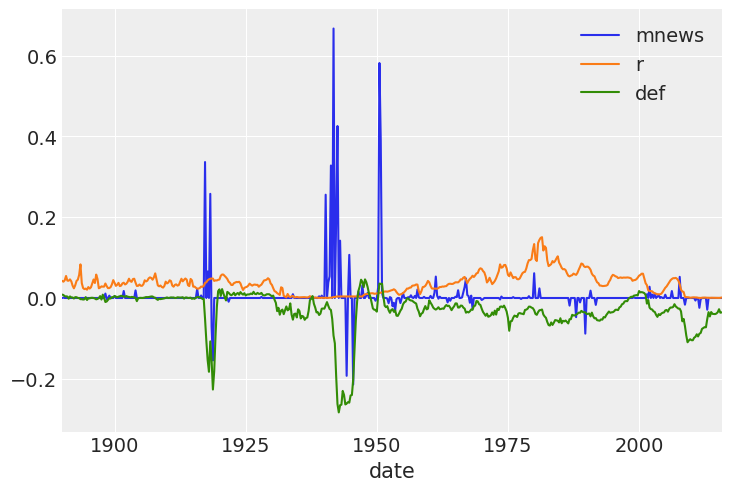

In [58]:
df[["mnews", "r", "def"]].plot()

Stock variables: Debt (debt)

<Axes: xlabel='date'>

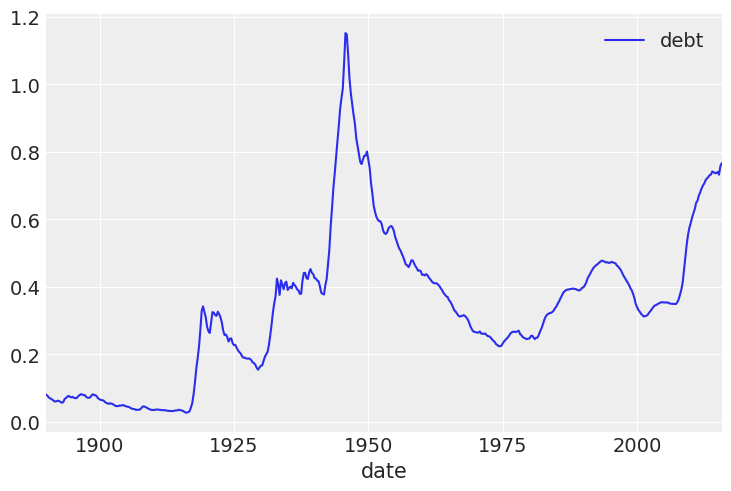

In [59]:
df[["debt"]].plot()

Logged variables: Government spending (gspend), GDP (gdp), and Total Factor Productivity (TFP)

<Axes: xlabel='date'>

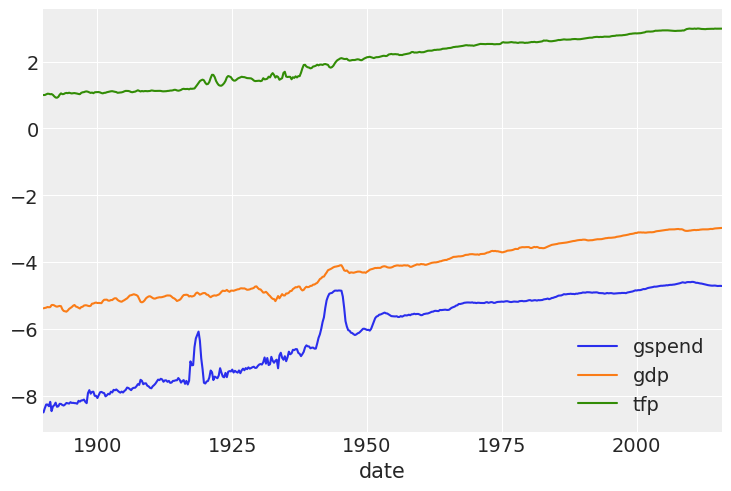

In [60]:
df[['gspend','gdp','tfp']].plot()

In [61]:
df.index[:10]

DatetimeIndex(['1890-01-01', '1890-04-01', '1890-07-01', '1890-10-01',
               '1891-01-01', '1891-04-01', '1891-07-01', '1891-10-01',
               '1892-01-01', '1892-04-01'],
              dtype='datetime64[ns]', name='date', freq='QS-OCT')

In [62]:
variables = ["mnews", "r", "def"]

data = df[variables][:-16] #Leave off last four years
test_data = df[variables][-16:]
data.shape, test_data.shape

((488, 3), (16, 3))

In [70]:
from matplotlib.colors import ColorConverter
colors = ("C0", "C1", "C2")

dark = {
    "C0": tuple(c * .35 for c in (ColorConverter.to_rgb("C0"))),
    "C1": tuple(c * .35 for c in (ColorConverter.to_rgb("C1"))),
    "C2": tuple(c * .35 for c in (ColorConverter.to_rgb("C2"))),
}

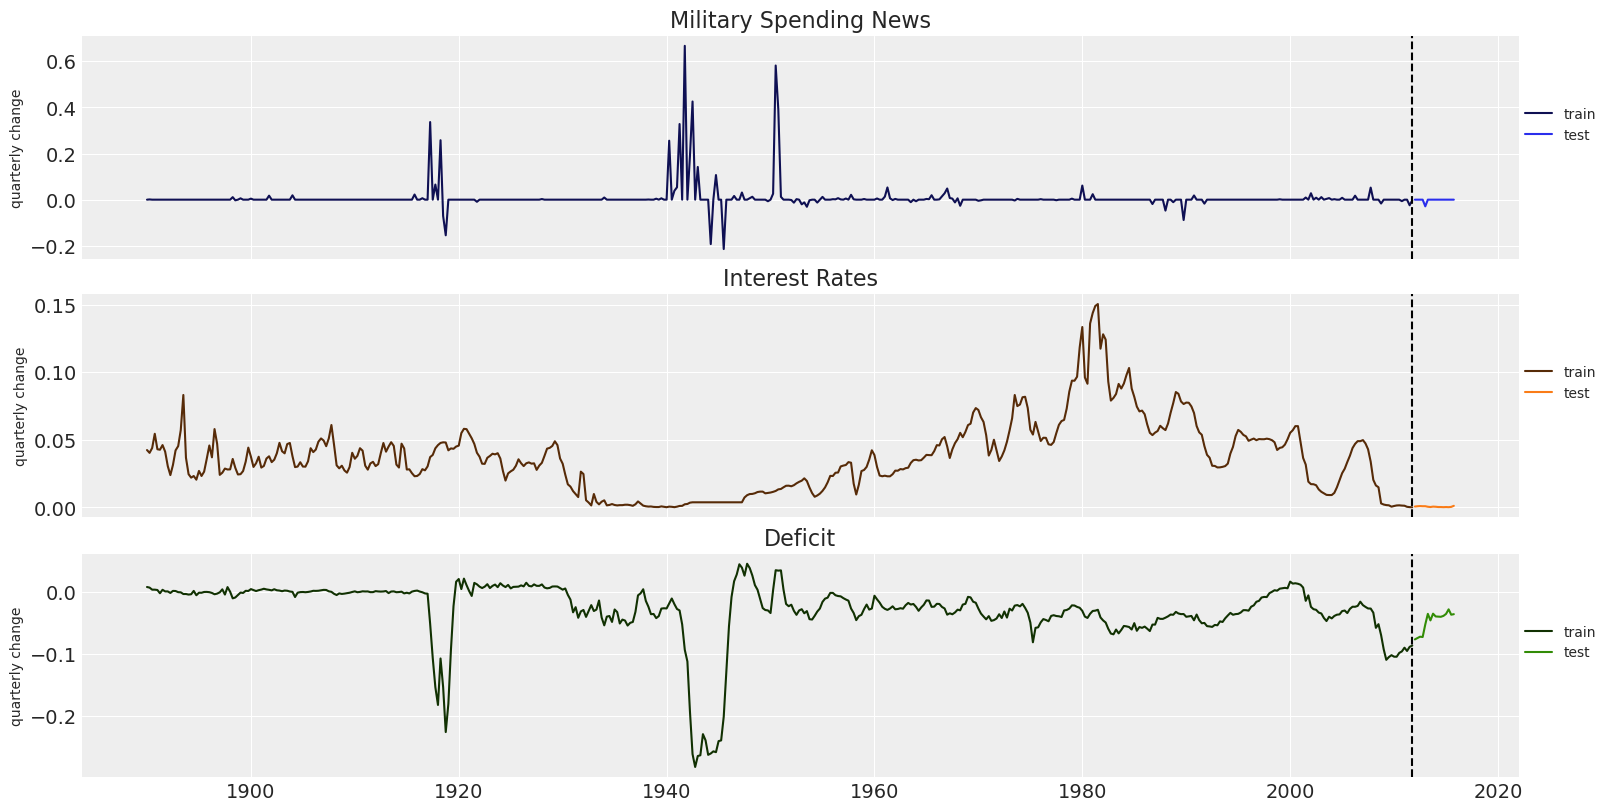

In [73]:
_, ax = plt.subplots(3, 1, figsize=(16, 8), sharex=True)
ax[0].plot(data["mnews"], color=dark["C0"], label="train")
ax[0].plot(test_data["mnews"], color="C0", label="test")
ax[0].set_ylabel("quarterly change", fontsize=10)
ax[0].set_title("Military Spending News")

ax[1].plot(data["r"], color=dark["C1"], label="train")
ax[1].plot(test_data["r"], color="C1", label="test")
ax[1].set_ylabel("quarterly change", fontsize=10)
ax[1].set_title("Interest Rates");

ax[2].plot(data["def"], color=dark["C2"], label="train")
ax[2].plot(test_data["def"], color="C2", label="test")
ax[2].set_ylabel("quarterly change", fontsize=10)
ax[2].set_title("Deficit");

for axi in ax:
    axi.axvline(data.index[-1], ls="--", color="k")
    axi.legend(loc=(1, 0.5), fontsize=10)

In [107]:
lags = 60

coords={
    "lags": reversed(range(-lags, 0)),
    "vars": ("mnews", "r", "def"),
    "cross_vars": ("mnews", "r", "def"),
    "time": range(len(data) - lags),
}

with pm.Model(coords=coords) as BVAR_model:
    # The first B bit:
    # Priors for the model intercept, lagged coefficients and noise terms
    intercept = pm.Normal("intercept", mu=0, sigma=1, dims=("vars",))
    lag_coefs = pm.Normal("lag_coefs", mu=0, sigma=1, dims=("lags", "vars", "cross_vars"))
    noise = pm.HalfNormal("noise", dims=("vars",))
    
    # The VAR bit:
    # Compute autoregressive expectation for each variable
    # We convolve the lagged coefficients of each variable with the whole dataset
    ar_mnews = pm.math.sum([
        pm.math.sum(lag_coefs[i, 0] * data.values[lags-(i+1): -(i+1)], axis=-1)
        for i in range(lags)
    ], axis=0)        
    ar_r = pm.math.sum([
        pm.math.sum(lag_coefs[i, 1] * data.values[lags-(i+1): -(i+1)], axis=-1)
        for i in range(lags)
    ], axis=0)
    ar_def = pm.math.sum([
        pm.math.sum(lag_coefs[i, 1] * data.values[lags-(i+1): -(i+1)], axis=-1)
        for i in range(lags)
    ], axis=0)   
    
    # Stack autoregressive terms and add intercepts
    mean = intercept + pm.math.stack([ar_mnews, ar_r, ar_def], axis=-1)
    
    # The second B bit:
    # For modelling simplicity, we ignore the first observations, where we could
    # not observe the effects of all the lagged coefficients
    obs = pm.Normal("obs", mu=mean, sigma=noise, observed=data[lags:], dims=("time", "vars"))

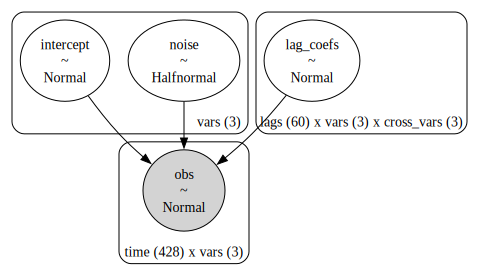

In [108]:
pm.model_to_graphviz(BVAR_model)

In [109]:
with BVAR_model:
    trace = pm.sample(chains=4, random_seed=rng)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, lag_coefs, noise]


Output()

ValueError: Not enough samples to build a trace.

In [ ]:
az.plot_trace(trace);

In [ ]:
az.plot_forest(trace, var_names=["intercept", "lag_coefs"], combined=True, textsize=10)
plt.axvline(0, color="k", ls="--")
plt.title("Posterior 94% HDI");

In [ ]:
# Function that takes a single draw of parameters and forecasts n steps
def _forecast(intercept, lag_coefs, noise, forecast=16):
    len_data = len(data)
    new_draws = np.zeros((data.shape[0]+forecast, data.shape[1]))
    # Fill the new array with the observed data
    new_draws[:len_data] = data[:]
    for i in range(forecast):
        ar_mnews = np.sum(lag_coefs[:, 0] * new_draws[len_data+i-lags: len_data+i])
        ar_r = np.sum(lag_coefs[:, 1] * new_draws[len_data+i-lags: len_data+i])
        ar_def = np.sum(lag_coefs[:, 1] * new_draws[len_data+i-lags: len_data+i])
        mean = intercept + np.stack([ar_mnews, ar_r, ar_def])
        new_draws[len_data+i] = rng.normal(mean, noise)
    # Replace all observed data with nan, so they don't show when we plot it
    new_draws[:-forecast-1] = np.nan
    return new_draws

# Vectorized forecast function to handle multiple parameter draws
forecast = np.vectorize(
    _forecast,
    signature=("(v),(l,v,v),(v)->(o,v)"),
    excluded=("forecast",),
)

In [ ]:
# Take a random subset of 100 draws from the posterior
draws = rng.integers(4000, size=100)

post = trace.posterior.stack(sample=("chain", "draw"))
intercept_draws = post["intercept"].values.T[draws]

lag_coefs_draws = post["lag_coefs"].values.T[draws].T
lag_coefs_draws = np.moveaxis(lag_coefs_draws, -1, 0)

noise_draws = post["noise"].values.T[draws]

In [ ]:
intercept_draws.shape, lag_coefs_draws.shape, noise_draws.shape

In [ ]:
# Forecast 10 quarters into the future
ppc_draws = forecast(intercept_draws, lag_coefs_draws, noise_draws, forecast=16)
ppc_draws = np.swapaxes(ppc_draws, 0, 1)
_, ax = plt.subplots(3, 1, sharex=True, figsize=(16, 8))

ax[0].set_title("mnews")
ax[0].plot(df.index, ppc_draws[..., 0], color="C0", alpha=0.05)
ax[0].plot(df["mnews"], color="k", label="observed")
ax[0].plot([], color="C0", label="forecast")

ax[1].set_title("r")
ax[1].plot(df.index, ppc_draws[..., 1], color="C1", alpha=0.05)
ax[1].plot(df["r"], color="k", label="observed")
ax[1].plot([], color="C1", label="forecast")

ax[2].set_title("def")
ax[2].plot(df.index, ppc_draws[..., 1], color="C2", alpha=0.05)
ax[2].plot(df["def"], color="k", label="observed")
ax[2].plot([], color="C2", label="forecast")

for axi in ax:
    axi.axvline(data.index[-1], ls="--", color="k")
    axi.legend(fontsize=10, loc=(1, .4))
    axi.set_ylabel("quarterly change", fontsize=12)

plt.tight_layout()